In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
import xgboost as xgb
import seaborn as sns
import pickle
warnings.filterwarnings("ignore")
random_seed = 8

In [2]:
# collected form each main diabetic indicator features regressors
cols = np.unique(
    [
        "AGE","FIELD_31","FIELD_33","FIELD_38","FIELD_40","L100500","L100700","L100800","L101200","L101300",
        "L101600","L101700","L103000","L103100","L103300","L104600","L107400","L190000","L190300","L190400",
        "S000100","S000300","S000501","S000502","SEX","FIELD_1","FIELD_2","FIELD_16","FIELD_23","FIELD_15",
        "FIELD_22","FIELD_17","FIELD_24",'CLASS'
    ]
)

In [3]:
xcols=[]
ycols=[]
allxycols=[]

for i in cols:
    xcols.append (i+'_x')
    ycols.append (i+'_y')
    
    allxycols.append (i+'_x')
    allxycols.append (i+'_y')

Read Dataset
====

In [4]:
x_original = pd.read_csv("../../XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original=x_original #[cols]

In [5]:
y_original = pd.read_csv("../../TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original=y_original #[cols]

In [6]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

In [7]:
print('x_original',x_original.shape)
print('y_original',y_original.shape)
print('data.shape',data.shape)

x_original (185843, 409)
y_original (185843, 409)
data.shape (185843, 817)


Prepare dataset
===

In [8]:
# filter the data set
data = data[data.FIELD_16_x != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23_x != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15_x != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22_x != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17_x != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24_x != 1
]  # exclude people who are on medication for hyperlipidemia


print(data.shape)

(169024, 817)


In [9]:

data = data[allxycols].dropna()
print(data.shape)

(41525, 68)


(array([30336.,     0.,     0.,     0.,     0., 10676.,     0.,     0.,
            0.,   513.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

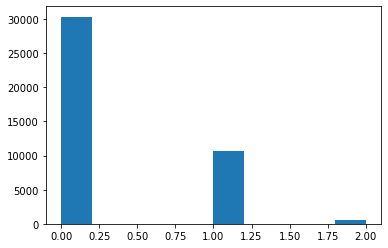

In [10]:
from matplotlib import pyplot as plt
plt.hist(data.CLASS_x,bins=10)

In [11]:
# print(data[data.AGE_x < 40].shape)
# data=data[data.AGE_x < 40]

In [12]:
x = data[xcols]
y = data[ycols]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.2)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [14]:

# xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=42, test_size=0.2)

Train Regression Models
==========

L104600_y # HBA1C
====

In [15]:

train=xtrain[
        [
            "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","L101700_x",
            "L190000_x","L101600_x","L190300_x"
        ]
    ]

# scaler=scaler.fit(train)"S000502_x","S000501_x",
# train=scaler.transform(train)

test=xtest[
        [
           "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","L101700_x",
            "L190000_x","L101600_x","L190300_x"
        ]
    ]


# test=scaler.transform(test),"S000501_x","S000502_x"

regr = RandomForestRegressor(
    max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
)


regr.fit(
    train
    ,
    ytrain[["L104600_y"]],
)

ypred = regr.predict(
    test
)

print("r2_score", m.r2_score(ytest[["L104600_y"]], ypred))

r2_score 0.6259550862538017


In [ ]:
ypred_train = regr.predict(
    train
)

print("r2_score", m.r2_score(ytest[["L104600_y"]], ypred))

In [36]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(regr, x, y, cv=5)
scores

KeyboardInterrupt: 

In [37]:
pred_L104600 = ypred

# with open('models/DiabeticModel_nextyear_L104600_RF_regressor', 'wb') as f:
#     pickle.dump(regr, f)    

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=11, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model= wider_model()

# # compile the keras model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
history=model.fit(xtrain[ [ "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x",
                                             "L101700_x","S000502_x","L190000_x","L101600_x","L190300_x",
                                              ] ].to_numpy(), ytrain[["L104600_y"]].to_numpy(), 
                  epochs=100, batch_size=100,validation_split=.2)

# # evaluate model with standardized dataset
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=500, verbose=1)))
# pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=10)
# results = cross_val_score(pipeline, xtrain[ [ "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x",
#                                              "L101700_x","S000502_x","L190000_x","L101600_x","L190300_x",
#                                              'CLASS_x' ] ].to_numpy(), ytrain[["L104600_y"]].to_numpy(), cv=kfold)
# print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
temppred=model.predict(
    xtest[
        [
           "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x","L101700_x","S000502_x",
            "L190000_x","L101600_x","L190300_x"
        ]
    ]
)

print("r2_score", m.r2_score(ytest[["L104600_y"]], ypred))

In [ ]:
from sklearn.svm import SVR
# most important SVR parameter is Kernel type. It can be #linear,polynomial or gaussian SVR. We have a non-linear condition #so we can select polynomial or gaussian but here we select RBF(a #gaussian type) kernel.
regressor = SVR(kernel='rbf',C=10)
regressor.fit(xtrain[ [ "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x",
                                             "L101700_x","S000502_x","L190000_x","L101600_x","L190300_x",
                                              ] ].to_numpy(), ytrain[["L104600_y"]].to_numpy())

In [ ]:
temppred=regressor.predict(
    xtest[
        [
           "L104600_x","L100800_x","S000300_x","AGE_x","L101300_x","S000501_x","L101700_x","S000502_x",
            "L190000_x","L101600_x","L190300_x"
        ]
    ]
)

print("r2_score", m.r2_score(ytest[["L104600_y"]], ypred))

L103000 #Triglyceride
=====

In [ ]:
regr = RandomForestRegressor(
    max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
)
regr.fit(
    xtrain[
        [
            "L103000_x",
            "L100700_x",
            "L101700_x",
            "S000300_x",
            "S000502_x",
            "FIELD_33_x",
            "L190000_x",
            "L100800_x",
            "L101600_x",
            "S000501_x",
        ]
    ],
    ytrain[["L103000_y"]],
)

ypred = regr.predict(
    xtest[
        [
            "L103000_x",
            "L100700_x",
            "L101700_x",
            "S000300_x",
            "S000502_x",
            "FIELD_33_x",
            "L190000_x",
            "L100800_x",
            "L101600_x",
            "S000501_x",
        ]
    ]
)

print("r2_score", m.r2_score(ytest[["L103000_y"]], ypred))

In [ ]:
pred_L103000 = ypred
with open('models/DiabeticModel_nextyear_L103000_RF_regressor', 'wb') as f:
    pickle.dump(regr, f)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L103000_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

S000300 #BMI
===

In [ ]:
regr = RandomForestRegressor(
    max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
)
regr.fit(
    xtrain[
        [
            "S000300_x",
            "L103300_x",
            "S000501_x",
            "L100700_x",
            "SEX_x",
            "L103100_x",
            "L190300_x",
            "L190400_x",
            "L101300_x",
            "S000502_x",
        ]
    ],
    ytrain[["S000300_y"]],
)

ypred = regr.predict(
    xtest[
        [
            "S000300_x",
            "L103300_x",
            "S000501_x",
            "L100700_x",
            "SEX_x",
            "L103100_x",
            "L190300_x",
            "L190400_x",
            "L101300_x",
            "S000502_x",
        ]
    ]
)

print("r2_score", m.r2_score(ytest[["S000300_y"]], ypred))

In [ ]:
pred_S000300 = ypred

with open('models/DiabeticModel_nextyear_S000300_RF_regressor', 'wb') as f:
    pickle.dump(regr, f)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["S000300_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

L101700 # r-GTP gamma
===

In [ ]:
regr = RandomForestRegressor(
    max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
)
regr.fit(
    xtrain[
        [
            "L101700_x",
            "L101300_x",
            "L103000_x",
            "SEX_x",
            "L100700_x",
            "L101200_x",
            "S000300_x",
            "S000501_x",
            "L100800_x",
            "S000502_x",
            "L101600_x",
            "S000100_x",
        ]
    ],
    ytrain[["L101700_y"]],
)

ypred = regr.predict(
    xtest[
        [
            "L101700_x",
            "L101300_x",
            "L103000_x",
            "SEX_x",
            "L100700_x",
            "L101200_x",
            "S000300_x",
            "S000501_x",
            "L100800_x",
            "S000502_x",
            "L101600_x",
            "S000100_x",
        ]
    ]
)

print("r2_score", m.r2_score(ytest[["L101700_y"]], ypred))

In [ ]:
pred_L101700 = ypred

with open('models/DiabeticModel_nextyear_L101700_RF_regressor', 'wb') as f:
    pickle.dump(regr, f)

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L101700_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

L100700 #Uric acid
====

In [ ]:
regr = RandomForestRegressor(
    max_depth=10, random_state=random_seed, verbose=0, n_estimators=300, max_features=8
)
regr.fit(
    xtrain[
        [
            "L100700_x",
            "L100500_x",
            "S000100_x",
            "S000300_x",
            "L103300_x",
            "L103000_x",
            "L103100_x",
            "S000501_x",
            "L101300_x",
            "L101700_x",
            "S000502_x",
            "L107400_x",
        ]
    ],
    ytrain[["L100700_y"]],
)

ypred = regr.predict(
    xtest[
        [
            "L100700_x",
            "L100500_x",
            "S000100_x",
            "S000300_x",
            "L103300_x",
            "L103000_x",
            "L103100_x",
            "S000501_x",
            "L101300_x",
            "L101700_x",
            "S000502_x",
            "L107400_x",
        ]
    ]
)

print("r2_score", m.r2_score(ytest[["L100700_y"]], ypred))

In [ ]:
pred_L100700 = ypred

with open('models/DiabeticModel_nextyear_L100700_RF_regressor', 'wb') as f:
    pickle.dump(regr, f)
    

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

ypredPD=pd.DataFrame() 
ypredPD['t + 1']=ytest[["L100700_y"]].values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

Categorical values
=====

In [ ]:
pred_FIELD_33 = ytest.FIELD_33_y

In [ ]:
pred_FIELD_38 = ytest.FIELD_38_y

In [ ]:
pred_FIELD_40 = ytest.FIELD_40_y

In [ ]:
pred_FIELD_31 = ytest.FIELD_31_y

In [ ]:
pred_SEX = ytest.SEX_y

In [ ]:
pred_AGE = ytest.AGE_y + 1

Combine the predicted values to make dataframe
====

In [ ]:
NextYearData = pd.DataFrame()
NextYearData["P_FIELD_1"] = ytest.FIELD_1_y.values
NextYearData["P_FIELD_2"] = ytest.FIELD_2_y.values
NextYearData["P_L104600"] = pred_L104600
NextYearData["P_L103000"] = pred_L103000
NextYearData["P_S000300"] = pred_S000300
NextYearData["P_L101700"] = pred_L101700
NextYearData["P_L100700"] = pred_L100700
NextYearData["P_FIELD_33"] = pred_FIELD_33.values
NextYearData["P_FIELD_38"] = pred_FIELD_38.values
NextYearData["P_FIELD_40"] = pred_FIELD_40.values
NextYearData["P_FIELD_31"] = pred_FIELD_31.values
NextYearData["P_SEX"] = pred_SEX.values
NextYearData["P_AGE"] = pred_AGE.values

NextYearData["P_AGE"] = pred_AGE.values
NextYearData["P_AGE"] = pred_AGE.values


NextYearData["A_L100800"] = ytest.L100800_y.values

conditions = [
    (NextYearData.A_L100800 < 100),
    (NextYearData.A_L100800 >= 100) & (NextYearData.A_L100800 < 126),
    (NextYearData.A_L100800 >= 126),
]
choices = [0, 1, 2]
NextYearData["A_CLASS"] = np.select(conditions, choices, default=0)
NextYearData.head()

In [ ]:
NextYearData.to_csv("Predicted_NextYearData.txt", sep=",")

==============================================
==========

In [ ]:
# select the actual next year values

NextYearData_actualData = pd.DataFrame()
NextYearData_actualData["FIELD_1"] = ytest.FIELD_1_y.values
NextYearData_actualData["FIELD_2"] = ytest.FIELD_2_y.values
NextYearData_actualData["L104600"] = ytest.L104600_y.values
NextYearData_actualData["L103000"] = ytest.L103000_y.values
NextYearData_actualData["S000300"] = ytest.S000300_y.values
NextYearData_actualData["L101700"] = ytest.L101700_y.values
NextYearData_actualData["L100700"] = ytest.L100700_y.values
NextYearData_actualData["FIELD_33"] = ytest.FIELD_33_y.values
NextYearData_actualData["FIELD_38"] = ytest.FIELD_38_y.values
NextYearData_actualData["FIELD_40"] = ytest.FIELD_40_y.values
NextYearData_actualData["FIELD_31"] = ytest.FIELD_31_y.values
NextYearData_actualData["SEX"] = ytest.SEX_y.values
NextYearData_actualData["AGE"] = ytest.AGE_y.values

NextYearData_actualData["L100800"] = ytest.L100800_y.values

conditions = [
    (NextYearData_actualData.L100800 < 100),
    (NextYearData_actualData.L100800 >= 100) & (NextYearData_actualData.L100800 < 126),
    (NextYearData_actualData.L100800 >= 126),
]
choices = [0, 1, 2]
NextYearData_actualData["CLASS"] = np.select(conditions, choices, default=0)
NextYearData_actualData.head()

NextYearData_actualData.to_csv("NextYearData_actualData_test.txt", sep=",")

==========================================================
===

In [ ]:
# select the actual this year values

ThisYearData_actualData = pd.DataFrame()
ThisYearData_actualData["FIELD_1"] = xtest.FIELD_1_x.values
ThisYearData_actualData["FIELD_2"] = xtest.FIELD_2_x.values
ThisYearData_actualData["L104600"] = xtest.L104600_x.values
ThisYearData_actualData["L103000"] = xtest.L103000_x.values
ThisYearData_actualData["S000300"] = xtest.S000300_x.values
ThisYearData_actualData["L101700"] = xtest.L101700_x.values
ThisYearData_actualData["L100700"] = xtest.L100700_x.values
ThisYearData_actualData["FIELD_33"] = xtest.FIELD_33_x.values
ThisYearData_actualData["FIELD_38"] = xtest.FIELD_38_x.values
ThisYearData_actualData["FIELD_40"] = xtest.FIELD_40_x.values
ThisYearData_actualData["FIELD_31"] = xtest.FIELD_31_x.values
ThisYearData_actualData["SEX"] = xtest.SEX_x.values
ThisYearData_actualData["AGE"] = xtest.AGE_x.values
ThisYearData_actualData["L100800"] = xtest.L100800_x.values

conditions = [
    (ThisYearData_actualData.L100800 < 100),
    (ThisYearData_actualData.L100800 >= 100) & (ThisYearData_actualData.L100800 < 126),
    (ThisYearData_actualData.L100800 >= 126),
]
choices = [0, 1, 2]
ThisYearData_actualData["CLASS"] = np.select(conditions, choices, default=0)
ThisYearData_actualData.head()

ThisYearData_actualData.to_csv("ThisYearData_actualData_test.txt", sep=",")

============================================
=========

In [ ]:
# select the actual next year values train

NextYearData_actualData_train = pd.DataFrame()
NextYearData_actualData_train["FIELD_1"] = ytrain.FIELD_1_y.values
NextYearData_actualData_train["FIELD_2"] = ytrain.FIELD_2_y.values
NextYearData_actualData_train["L104600"] = ytrain.L104600_y.values
NextYearData_actualData_train["L103000"] = ytrain.L103000_y.values
NextYearData_actualData_train["S000300"] = ytrain.S000300_y.values
NextYearData_actualData_train["L101700"] = ytrain.L101700_y.values
NextYearData_actualData_train["L100700"] = ytrain.L100700_y.values
NextYearData_actualData_train["FIELD_33"] = ytrain.FIELD_33_y.values
NextYearData_actualData_train["FIELD_38"] = ytrain.FIELD_38_y.values
NextYearData_actualData_train["FIELD_40"] = ytrain.FIELD_40_y.values
NextYearData_actualData_train["FIELD_31"] = ytrain.FIELD_31_y.values
NextYearData_actualData_train["SEX"] = ytrain.SEX_y.values
NextYearData_actualData_train["AGE"] = ytrain.AGE_y.values

NextYearData_actualData_train["L100800"] = ytrain.L100800_y.values

conditions = [
    (NextYearData_actualData_train.L100800 < 100),
    (NextYearData_actualData_train.L100800 >= 100)
    & (NextYearData_actualData_train.L100800 < 126),
    (NextYearData_actualData_train.L100800 >= 126),
]
choices = [0, 1, 2]
NextYearData_actualData_train["CLASS"] = np.select(conditions, choices, default=0)
NextYearData_actualData_train.head()

NextYearData_actualData_train.to_csv("NextYearData_actualData_train.txt", sep=",")

=================================================
==============

In [ ]:
# select the actual this year values train

ThisYearData_actualData_train = pd.DataFrame()
ThisYearData_actualData_train["FIELD_1"] = xtrain.FIELD_1_x.values
ThisYearData_actualData_train["FIELD_2"] = xtrain.FIELD_2_x.values
ThisYearData_actualData_train["L104600"] = xtrain.L104600_x.values
ThisYearData_actualData_train["L103000"] = xtrain.L103000_x.values
ThisYearData_actualData_train["S000300"] = xtrain.S000300_x.values
ThisYearData_actualData_train["L101700"] = xtrain.L101700_x.values
ThisYearData_actualData_train["L100700"] = xtrain.L100700_x.values
ThisYearData_actualData_train["FIELD_33"] = xtrain.FIELD_33_x.values
ThisYearData_actualData_train["FIELD_38"] = xtrain.FIELD_38_x.values
ThisYearData_actualData_train["FIELD_40"] = xtrain.FIELD_40_x.values
ThisYearData_actualData_train["FIELD_31"] = xtrain.FIELD_31_x.values
ThisYearData_actualData_train["SEX"] = xtrain.SEX_x.values
ThisYearData_actualData_train["AGE"] = xtrain.AGE_x.values
ThisYearData_actualData_train["L100800"] = xtrain.L100800_x.values

conditions = [
    (ThisYearData_actualData_train.L100800 < 100),
    (ThisYearData_actualData_train.L100800 >= 100)
    & (ThisYearData_actualData_train.L100800 < 126),
    (ThisYearData_actualData_train.L100800 >= 126),
]
choices = [0, 1, 2]
ThisYearData_actualData_train["CLASS"] = np.select(conditions, choices, default=0)
ThisYearData_actualData_train.head()

ThisYearData_actualData_train.to_csv("ThisYearData_actualData_train.txt", sep=",")